In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Загрузка данных в датафрейм
data = pd.read_csv('athletes.csv')
data.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


1. Преобразование данных.

In [ ]:
# Информация о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


В данных есть пропуски. Один пропуск значения даты рождения и несколько пропусков в данных о росте и весе спортсменов.

In [ ]:
# Количество уникальных дней рождения
len(data['dob'].unique())

5596

In [ ]:
data = data.dropna(subset=['dob'])
data = data.dropna(subset=['height'])
data = data.dropna(subset=['weight'])

Одну строку с пропуском даты рождения удалю из датафрейма. Во-первых не вполне понятно, чем такое значение можно заменить. Во-вторых - количество уникальных значений в датафрейме сильно велико и я не планирую в принципе использовать этот признак для получения модели.

Строки с пропусками данных о росте и весе спортсменов тоже можно было бы удалить из датафрейма. Их небольшое количество, порядка 6% от общего количества.

In [ ]:
# Процент пропущеных значений в столбцах 'height' и 'weight' соответственно
# f"{round(data['height'].isnull().sum()/len(data)*100, 2)}%", f"{round(data['weight'].isnull().sum()/len(data)*100, 2)}%"

('0.0%', '0.0%')

Но я бы хотел произвести замену пропусков средним значением роста и веса отдельно для мужчин и женщин. Можно было бы посмотреть еще дополнительно в разрезе видов спорта, но проведу моделирование для начала так, посмотрю на результаты и метрику качества. Потом приму решение, уточнять по виду спорта или нет.

In [ ]:
# Уникальны значения данных о весе и росте спортсменов
data['height'].unique(), data['weight'].unique()

(array([1.72, 1.68, 1.98, 1.83, 1.81, 1.8 , 2.05, 1.93, 1.65, 1.7 , 1.75,
        1.61, 1.78, 1.76, 2.1 , 1.73, 1.85, 1.77, 1.9 , 1.86, 1.74, 1.6 ,
        2.07, 1.66, 1.62, 1.87, 2.03, 1.69, 1.82, 1.89, 1.94, 1.88, 1.95,
        1.71, 1.84, 1.91, 2.02, 1.58, 1.63, 1.67, 1.79, 1.97, 1.56, 1.55,
        1.57, 1.46, 1.92, 1.64, 1.53, 1.99, 1.96, 2.  , 2.04, 1.47, 1.52,
        2.01, 1.51, 1.59, 2.08, 1.37, 1.5 , 1.45, 2.06, 1.54, 2.11, 1.43,
        1.49, 1.33, 1.44, 2.13, 1.48, 2.09, 2.21, 2.18, 1.21, 1.38, 1.34,
        2.15, 2.17, 1.42, 1.4 , 2.14]),
 array([ 64.,  56.,  79.,  80.,  71.,  67.,  98., 100.,  62.,  54.,  63.,
         66.,  49.,  68.,  57.,  88.,  65.,  72.,  75.,  70.,  95., 120.,
         90.,  60.,  73.,  84., 132.,  86.,  77.,  61.,  76.,  52.,  58.,
         81., 115., 130.,  92.,  94.,  93.,  85.,  82.,  55.,  78.,  83.,
         89.,  69.,  87.,  50., 105.,  53.,  47.,  59.,  51., 144.,  99.,
         48.,  44., 125.,  35.,  46.,  74., 113., 102.,  96., 107., 110.

Меня насторажили небольшие значения веса некоторых спотсменов, от 31 до 40 кг. У меня нет данных о дате, когда был создан датафрейм, но скорее всего на момент сбора данных это были достаточно молодые спортсмены, причем почти все женского пола. В любом случае оставляем эти данные. Это просто наблюдение.

In [ ]:
# Перечень спортсменов, вес которых менее 40 кг
data.loc[data['weight'] < 40]

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
210,676958658,Aiko Sugihara,JPN,female,9/19/99,1.46,35.0,gymnastics,0,0,0
1210,568130066,Aslan Kakhidze,KAZ,male,10/28/88,1.85,39.0,wrestling,0,0,0
1221,137582033,Asuka Teramoto,JPN,female,11/19/95,1.45,37.0,gymnastics,0,0,0
1286,256843630,Ayuko Suzuki,JPN,female,10/8/91,1.54,39.0,athletics,0,0,0
2106,74882200,Chunsong Shang,CHN,female,3/18/96,1.43,34.0,gymnastics,0,0,1
3429,777180519,Flavia Saraiva,BRA,female,9/30/99,1.33,31.0,gymnastics,0,0,0
4890,497442355,Jiaxin Tan,CHN,female,12/3/96,1.48,36.0,gymnastics,0,0,1
5890,703248016,Kuk Hyang Kim,PRK,female,4/4/99,1.49,39.0,aquatics,0,0,0
7634,224192302,Miyuki Uehara,JPN,female,11/22/95,1.54,39.0,athletics,0,0,0
8339,500712109,Oreane Lechenault,FRA,female,8/31/00,1.34,37.0,gymnastics,0,0,0


Теперь заполню попуски в данных о весе и росте спортсменов средним значением в разрезе пола.

In [ ]:
# Значение среднего роста и веса для мужчин и женщин
# mean_height_male = round(data[(data.sex == 'male')]['height'].mean(), 2)
# mean_height_female = round(data[(data.sex == 'female')]['height'].mean(), 2)
# mean_weight_male = round(data[(data.sex == 'male')]['weight'].mean(), 0)
# mean_weight_female = round(data[(data.sex == 'female')]['weight'].mean(), 0)
# mean_height_male, mean_height_female, mean_weight_male, mean_weight_female

(1.82, 1.7, 80.0, 63.0)

In [ ]:
# Заполнение пропусков в столбце 'height' средним значением роста для мужского и женского пола соответственно
# data['height'] = data.apply(lambda row: mean_height_male if row['sex'] == 'male' else mean_height_female if row['sex'] == 'female' else row['height'], axis=1)

In [ ]:
# Заполнение пропусков в столбце 'weight' средним значением веса для мужского и женского пола соответственно
# data['weight'] = data.apply(lambda row: mean_weight_male if row['sex'] == 'male' else mean_weight_female if row['sex'] == 'female' else row['weight'], axis=1)

In [ ]:
# Проверю, что пропусков больше нет
# data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


In [ ]:
# В качестве целевой переменной используем пол, данные в общем сбалансированы, есть небольшой перекос в сторону значения 'male'
data['sex'].value_counts()

male      5862
female    4996
Name: sex, dtype: int64

Столбец y необходимо закодировать в числа.

In [ ]:
le = LabelEncoder()
le.fit(data['sex'])

LabelEncoder()

In [ ]:
# Запишу в таргетную переменную преобразованное значение столбца 'sex'
y = pd.Series(data=le.transform(data['sex']))
y.head()

0    1
1    0
2    1
3    1
4    1
dtype: int64

In [ ]:
# Возьму 3 признака для обучения модели
features = data[['height', 'weight', 'sport']]
features.head()

,height,weight,sport
0,1.72,64.0,athletics
1,1.68,56.0,fencing
2,1.98,79.0,athletics
3,1.83,80.0,taekwondo
4,1.81,71.0,cycling


Поскольку столбец 'sport' тоже категориальный, преобразуем его в 0 и 1.

In [ ]:
X = pd.get_dummies(features, columns=['sport'])
X.head()

,height,weight,sport_aquatics,sport_archery,sport_athletics,sport_badminton,sport_basketball,sport_canoe,sport_cycling,sport_equestrian,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
0,1.72,64.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.68,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.98,79.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.83,80.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.81,71.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


3. Разделю выборку на обучающую и тестовую.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучение модели логистической регрессии



In [ ]:
model = LogisticRegression(max_iter=1000)

In [ ]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([1, 1, 0, ..., 1, 0, 1])

In [ ]:
# Расчет Accuracy
model.score(X_train, y_train)

0.8174073221275616

3. Построение ROC-кривой с помощью функции sklearn.metrics. roc_curve

In [ ]:
predictions = model.predict_proba(X_test)
predictions

array([[0.27941362, 0.72058638],
       [0.06959065, 0.93040935],
       [0.77754825, 0.22245175],
       ...,
       [0.01857513, 0.98142487],
       [0.89949761, 0.10050239],
       [0.28621635, 0.71378365]])

In [ ]:
fpr, tpr, thres = roc_curve(y_test, predictions[:, 1])

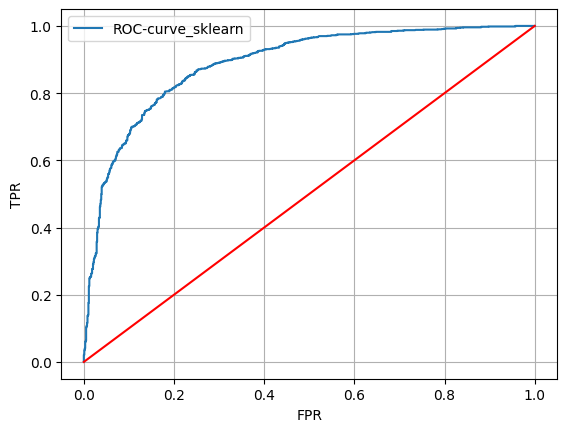

In [ ]:
plt.plot(fpr, tpr, label = 'ROC-curve_sklearn')
plt.plot(np.linspace(0,1), np.linspace(0,1), color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=0)
plt.grid()

4. Вычисление значения ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.

In [ ]:
roc_auc_score(y_test, predictions[:, 1])

0.887461590840656

5. Реализация подсчета метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.

In [ ]:
# Реализуем через функцию, в которую передадим значение y_test, предсказанное значение
def roc_curve(Y1, Y, thresholds):
  # Пустые списки для FPR, TPR
  fpr_calc_list = []
  tpr_calc_list = []
  recall_calc_list = []
  precision_calc_list = []

  # Переберем в цикле значение порога из списка:
  for threshold in thresholds:
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    # Переберем в цикле значение истинных и предсказанных значений целевой переменной и вычислим метрики TP, TN, FP, FN
    for predicted_prob, actual in zip(Y1, Y):
      if predicted_prob >= threshold:
        predicted = 1
      else:
        predicted = 0

      if predicted == 1:
        if actual == 1:
          tp += 1
        else:
          fp += 1

      else:
        if actual == 1:
          fn += 1
        else:
          tn += 1

    # Вычисление метрик TPR, FPR, Recall, Precision
    fpr_calc = fp / (fp + fn)
    tpr_calc = tp / (tp + fn)
    recall_calc = tpr_calc # формула одинакова
    precision_calc = tp / (tp + fp)

    # Добавление рассчитанных метрик TPR, FPR в списки
    fpr_calc_list.append(fpr_calc)
    tpr_calc_list.append(tpr_calc)
    recall_calc_list.append(recall_calc)
    precision_calc_list.append(precision_calc)

  # Вывод функции - списки рассчитанных метрик TPR, FPR
  return fpr_calc_list, tpr_calc_list, recall_calc_list, precision_calc_list

In [ ]:
thresholds = np.arange(0, 1, 0.05)
fpr_calc, tpr_calc, recall_calc, precision_calc = roc_curve(predictions[:, 1], y_test, thresholds)

In [ ]:
# Метрики FPR, TPR, расчитанные "вручную"
fpr_calc, tpr_calc

([1.0,
  0.9977528089887641,
  0.9829842931937173,
  0.9665653495440729,
  0.9424083769633508,
  0.8976833976833977,
  0.8370672097759674,
  0.7653508771929824,
  0.6746411483253588,
  0.5815085158150851,
  0.5024154589371981,
  0.40380047505938244,
  0.30227272727272725,
  0.22559652928416485,
  0.16600790513833993,
  0.11517367458866545,
  0.07487520798668885,
  0.051698670605613,
  0.034482758620689655,
  0.01166489925768823],
 [1.0,
  0.9983164983164983,
  0.9890572390572391,
  0.9814814814814815,
  0.9722222222222222,
  0.9553872053872053,
  0.9326599326599326,
  0.9099326599326599,
  0.8855218855218855,
  0.8552188552188552,
  0.8265993265993266,
  0.7887205387205387,
  0.7415824915824916,
  0.6994949494949495,
  0.6447811447811448,
  0.5925925925925926,
  0.531986531986532,
  0.4595959595959596,
  0.3400673400673401,
  0.21548821548821548])

In [ ]:
# Метрики Recall, Precision, расчитанные "вручную"
recall_calc, precision_calc

([1.0,
  0.9983164983164983,
  0.9890572390572391,
  0.9814814814814815,
  0.9722222222222222,
  0.9553872053872053,
  0.9326599326599326,
  0.9099326599326599,
  0.8855218855218855,
  0.8552188552188552,
  0.8265993265993266,
  0.7887205387205387,
  0.7415824915824916,
  0.6994949494949495,
  0.6447811447811448,
  0.5925925925925926,
  0.531986531986532,
  0.4595959595959596,
  0.3400673400673401,
  0.21548821548821548],
 [0.5469613259668509,
  0.5718418514946962,
  0.6100726895119418,
  0.6470588235294118,
  0.6814159292035398,
  0.709375,
  0.7294272547728768,
  0.7559440559440559,
  0.7886056971514243,
  0.8095617529880478,
  0.8252100840336134,
  0.8464317976513098,
  0.868836291913215,
  0.8887700534759359,
  0.9011764705882352,
  0.9178617992177314,
  0.9335302806499262,
  0.9397590361445783,
  0.9351851851851852,
  0.9588014981273408])

6. Построение ROC-кривой с помощью вычисленных "вручную" параметров FPR, TPR.

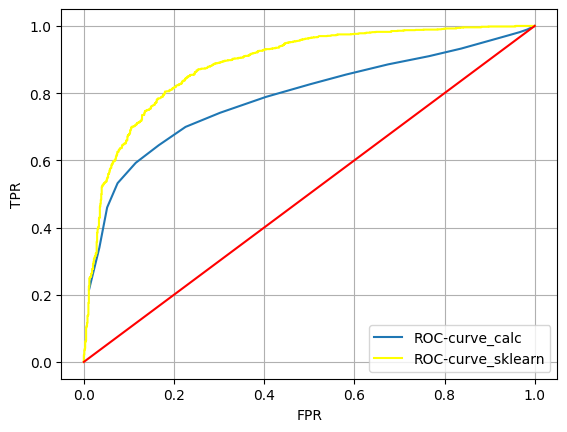

In [ ]:
# Расчетная ROC-кривая
plt.plot(np.array(fpr_calc), np.array(tpr_calc), label = 'ROC-curve_calc')
# ROC-кривая из библиотеки sklearn
plt.plot(fpr, tpr, label = 'ROC-curve_sklearn', color = 'yellow')
plt.plot(np.linspace(0,1), np.linspace(0,1), color='red')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=0)
plt.grid()
plt.show()

7. Построение графика Precision-Recall с помощью вычисленных "вручную" параметров.

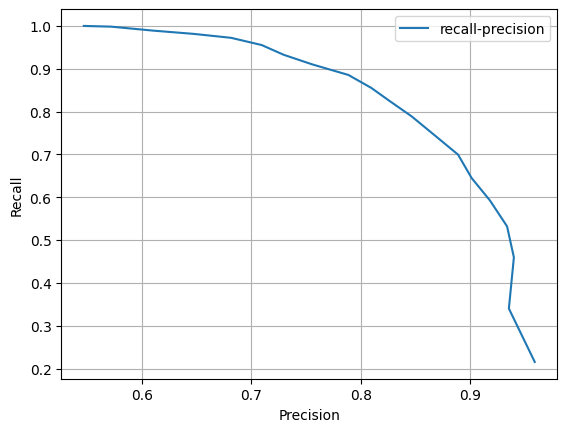

In [ ]:
plt.plot(np.array(precision_calc), np.array(recall_calc), label = 'recall-precision')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc=0)
plt.grid()
plt.show()

8. Вычисление значения ROC-AUC метрики с помозью вычисленных вручную параметров.

In [ ]:
from scipy.integrate import trapz

In [ ]:
# Сортировка массивов по X (в нашем случае по fpr)
sorted_indices = np.argsort(np.array(fpr_calc))
x_1 = np.array(fpr_calc)[sorted_indices]
y_1 = np.array(tpr_calc)[sorted_indices]

In [ ]:
ROC_AUC_calc = trapz(y_1, x_1)
ROC_AUC_calc

0.783553040083909

ВЫВОДЫ:
1. По полученным графикам можно сделать следующие выводы - чем ближе площадь под графиком к 1 (что ROC-кривой, что график precision-recall) тем лучше модель и тем выше ее качество.
2. Исходя из рассчитанных метрик считаю, что в целом модель получилась неплохая, но далека от идеала.
3. Может ли ROC-кривая проходить ниже диагонали? Ответ - думаю, что да, может. Но поскольку мы имеем дело с бинарной классификацией, то это будет означать только то, что если мы поменяем классы местами график будет проходить выше диагонали.